# Decision Trees

Like  SVMs,  Decision  Trees  are  versatile  Machine  Learning  algorithms  that  can  perform  both  classification  and  regression  tasks,  and  even  multioutput  tasks.  They  are powerful  algorithms,  capable  of  fitting  complex  datasets.  Decision  Trees  are  also  the  fundamental  components  of  Random  Forests,  which  are  among  the  most  powerful  Machine  Learning  algorithms  available today. In  this  chapter  we  will  start  by  discussing  how  to  train,  visualize,  and  make  predictions  with  Decision  Trees.  Then  we  will  go  through  the  CART  training  algorithmused  by  Scikit-Learn,  and  we  will  discuss  how  to  regularize  trees  and  use  them  for regression tasks. Finally, we will discuss some of the limitations of Decision Trees.

## Training and Visualizing a Decision Tree

To understand Decision Trees, let’s build one and take a look at how it makes predictions.

In [1]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
import numpy as np

iris = load_iris()
X = iris.data[:, 2:] #petal length and width
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=2, random_state=42)

You  can  visualize  the  trained  Decision  Tree  by  first  using  the  export_graphviz() method to output a graph definition file called iris_tree.dot.

In [2]:
# setup not completed

from graphviz import Source
from sklearn.tree import export_graphviz
import os

IMAGES_PATH = os.path.join("/home/susang/Documents")

export_graphviz(
        tree_clf,
        out_file=os.path.join(IMAGES_PATH, "iris_tree.dot"),
        feature_names=iris.feature_names[2:],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

# Source.from_file(os.path.join(IMAGES_PATH, "iris_tree.dot"))

Then you can use the dot command-line tool from the Graphviz package to convert this  .dot  file  to  a  variety  of  formats,  such  as  PDF  or  PNG. This  command  line  converts the .dot file to a .png image file.

$ dot -Tpng iris_tree.dot -o iris_tree.png

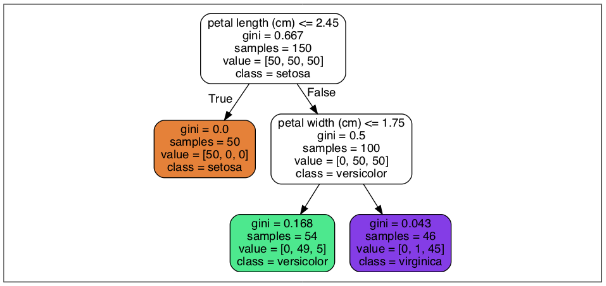

## Making Predictions

Let’s see how the tree represented in Figure above makes predictions. Suppose you find an  iris  flower  and  you  want  to  classify  it.  You  start  at  the  root  node  (depth  0,  at  the top): this node asks whether the flower’s petal length is smaller than 2.45 cm. If it is, then you move down to the root’s left child node (depth 1, left). In this case, it is a leaf node (i.e., it does not have any child nodes), so it does not ask any questions: simply look  at  the  predicted  class  for  that  node,  and  the  Decision  Tree  predicts  that  your flower is an Iris setosa (class=setosa).

Now  suppose  you  find  another  flower,  and  this  time  the  petal  length  is  greater  than 2.45 cm. You must move down to the root’s right child node (depth 1, right), which is not  a  leaf  node,  so  the  node  asks  another  question:  is  the  petal  width  smaller  than 1.75 cm? If it is, then your flower is most likely an Iris versi color (depth 2, left). If not,it is likely an Iris virginica (depth 2, right). It’s really that simple.

One  of  the  many  qualities  of  Decision  Trees  is  that  they  require very  little  data  preparation.  In  fact,  they  don’t  require  feature  scaling or centering at all.

A node’s  samples  attribute  counts  how  many  training  instances  it  applies  to.  For example,  100  training  instances  have  a  petal  length  greater  than  2.45  cm  (depth  1, right), and of those 100, 54 have a petal width smaller than 1.75 cm (depth 2, left). A node’s  value  attribute  tells  you  how  many  training  instances  of  each  class  this  node applies to: for example, the bottom-right node applies to 0 Iris setosa, 1 Iris versicolor,and  45  Iris  virginica.  Finally,  a  node’s  gini  attribute  measures  its  impurity:  a  node  is “pure”  (gini=0)  if  all  training  instances  it  applies  to  belong  to  the  same  class.  For example, since the depth-1 left node applies only to Iris setosa training instances, it is pure  and  its  gini  score  is  0.  Equation below shows  how  the  training  algorithm  computes the gini score G<sub>i</sub> of the i<sup>th</sup> node. The depth-2 left node has a gini score equal to1 – (0/54)<sup>2</sup> – (49/54)<sup>2</sup> – (5/54)<sup>2</sup> ≈ 0.168

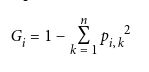

In this equation:
- p<sub>i,k</sub> is the ratio of class k instances among the training instances in the i<sup>th</sup> node.

Scikit-Learn uses the CART algorithm, which produces only binary trees:  nonleaf  nodes  always  have  two  children  (i.e.,  questions  only have  yes/no  answers).  However,  other  algorithms  such  as  ID3  can produce  Decision  Trees  with  nodes  that  have  more  than  two children.

Figure below shows this Decision Tree’s decision boundaries. The thick vertical line represents  the  decision  boundary  of  the  root  node  (depth  0):  petal  length  =  2.45  cm. Since the left hand area is pure (only Iris setosa), it can not be split any further. However, the right hand area is impure, so the depth-1 right node splits it at petal width =1.75 cm (represented by the dashed line). Since max_depth was set to 2, the DecisionTree  stops  right  there.  If  you  set  max_depth  to  3,  then  the  two  depth-2  nodes  would each add another decision boundary (represented by the dotted lines).

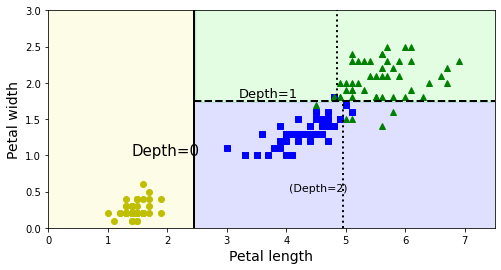

In [3]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)

plt.show()

### Model Interpretation: White Box Versus Black Box

Decision Trees are intuitive, and their decisions are easy to interpret. Such models are often  called  white  box  models.  In  contrast,  as  we  will  see,  Random  Forests  or  neural networks  are  generally  considered  black  box  models.  They  make  great  predictions, and  you  can  easily  check  the  calculations  that  they  performed  to  make  these  predictions;  nevertheless,  it  is  usually  hard  to  explain  in  simple  terms  why  the  predictions were made. For example, if a neural network says that a particular person appears on a picture, it is hard to know what contributed to this prediction: did the model recognize  that  person’s  eyes?  Their  mouth?  Their  nose?  Their  shoes?  Or  even  the  couch that  they  were  sitting  on?  Conversely,  Decision  Trees  provide  nice,  simple  classifica‐tion rules that can even be applied manually if need be (e.g., for flower classification).

## Estimating Class Probabilities

A Decision Tree can also estimate the probability that an instance belongs to a particular class k. First it traverses the tree to find the leaf node for this instance, and then it returns  the  ratio  of  training  instances  of  class  k  in  this  node.  For  example,  suppose you  have  found  a  flower  whose  petals  are  5  cm  long  and  1.5  cm  wide.  The corresponding leaf node is the depth-2 left node, so the Decision Tree should outputthe following probabilities: 0% for Iris setosa (0/54), 90.7% for Iris versicolor (49/54), and 9.3% for Iris virginica (5/54). And if you ask it to predict the class, it should output Iris versi color (class 1) because it has the highest probability. Let’s check this:

In [4]:
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [5]:
tree_clf.predict([[5, 1.5]])

array([1])

Notice  that  the  estimated  probabilities  would  be  identical  anywhere  else  in the  bottom right  rectangle  of  Figure  above for  example,  if  the  petals  were  6  cm  long and  1.5  cm  wide  (even  though  it  seems  obvious  that  it  would  most  likely  be  an  Iris virginica in this case).

## The CART Training Algorithm

Scikit-Learn  uses  the  Classification  and  Regression  Tree  (CART)  algorithm  to  train Decision Trees (also called “growing” trees). The algorithm works by first splitting the training  set  into  two  subsets  using  a  single  feature  k  and  a  threshold  t<sub>k</sub>  (e.g.,  “petallength  ≤  2.45  cm”).  How  does  it  choose  k  and  t<sub>k</sub>?  It  searches  for  the  pair  (k,  t<sub>k</sub>)  that produces the purest subsets (weighted by their size). Equation below gives the cost function that the algorithm tries to minimize.

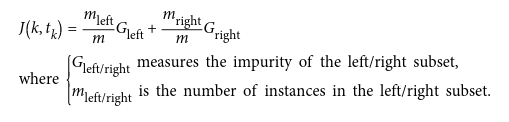

Once  the  CART  algorithm  has  successfully  split  the  training  set  in  two,  it  splits  the subsets  using  the  same  logic,  then  the  subsubsets,  and  so  on,  recursively.  It  stops recursing once it reaches the maximum depth (defined by the max_depth hyperparameter), or if it can not find a split that will reduce impurity. A few other hyperparameters (described     in     a     moment)     control     additional     stopping     conditions (min_samples_split,       min_samples_leaf,       min_weight_fraction_leaf,       and max_leaf_nodes).

As you can see, the CART algorithm is a greedy algorithm: it greedily  searches  for  an  optimum  split  at  the  top  level,  then  repeats  the process  at  each  subsequent  level.  It  does  not  check  whether  or  not the  split  will  lead  to  the  lowest  possible  impurity  several  levels down. A greedy algorithm often produces a solution that’s reasonably good but not guaranteed to be optimal. Unfortunately,  finding  the  optimal  tree  is  known  to  be  an  NP-Complete  problem:  it  requires  O(exp(m))  time,  making  the  problem  intractable  even  for  small  training  sets.  This  is  why  we  must settle for a “reasonably good” solution.

## Computational Complexity

Making  predictions  requires  traversing  the  Decision  Tree  from  the  root  to  a  leaf. Decision Trees generally are approximately balanced, so traversing the Decision Tree requires  going  through  roughly  O(log2(m))  nodes.  Since  each  node  only  requires checking  the  value  of  one  feature,  the  overall  prediction  complexity  is  O(log2(m)), independent of the number of features. So predictions are very fast, even when dealing with large training sets. The  training  algorithm  compares  all  features  (or  less  if  max_features  is  set)  on  all samples at each node. Comparing all features on all samples at each node results in a training complexity of O(n × m log2(m)). For small training sets (less than a few thousand  instances),  Scikit-Learn  can  speed  up  training  by  presorting  the  data  (set  presort=True), but doing that slows down training considerably for larger training sets.

## Gini Impurity or Entropy?

By default, the Gini impurity measure is used, but you can select the entropy impurity measure instead by setting the criterion hyperparameter to "entropy". The concept of  entropy  originated  in  thermodynamics  as  a  measure  of  molecular  disorder: entropy  approaches  zero  when  molecules  are  still  and  well  ordered.  Entropy  later spread to a wide variety of domains, including Shannon’s information theory, where it measures  the  average  information  content  of  a  message:   entropy  is  zero  when  all messages  are  identical.  In  Machine  Learning,  entropy  is  frequently  used  as  an impurity measure: a set’s entropy is zero when it contains instances of only one class. Equation below  shows  the  definition  of  the  entropy  of  the  i<sup>th</sup>  node.  For  example,  thedepth-2 left node in Figure of tree visualizaton has an entropy equal to –(49/54)log2 (49/54) – (5/54)log2(5/54) ≈ 0.445.

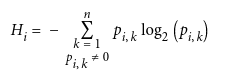

So,  should  you  use  Gini  impurity  or  entropy?  The  truth  is,  most  of  the  time  it  does not make a big difference: they lead to similar trees. Gini impurity is slightly faster to compute,  so  it  is  a  good  default.  However,  when  they  differ,  Gini  impurity  tends  to isolate  the  most  frequent  class  in  its  own  branch  of  the  tree,  while  entropy  tends  to produce slightly more balanced trees.

## Regularization Hyperparameters

Decision Trees make very few assumptions about the training data (as opposed to linear  models,  which  assume  that  the  data  is  linear,  for  example).  If  left  unconstrained, the tree structure will adapt itself to the training data, fitting it very closely indeed, most  likely  overfitting  it.  Such  a  model  is  often  called  a  non parametric  model,  not because it does not have any parameters (it often has a lot) but because the number of parameters is not determined prior to training, so the model structure is free to stick closely to the data. In contrast, a parametric model, such as a linear model, has a predetermined  number  of  parameters,  so  its  degree  of  freedom  is  limited,  reducing  the risk of overfitting (but increasing the risk of underfitting). To avoid overfitting the training data, you need to restrict the Decision Tree’s freedom during training. As you know by now, this is called regularization. The regularization hyperparameters depend on the algorithm used, but generally you can at least restrict the  maximum  depth  of  the  Decision  Tree.  In  Scikit-Learn,  this  is  controlled  by  the max_depth  hyperparameter  (the  default  value  is  None,  which  means  unlimited). Reducing max_depth will regularize the model and thus reduce the risk of overfitting. The DecisionTreeClassifier class has a few other parameters that similarly restrictthe  shape  of  the  Decision  Tree:  min_samples_split  (the  minimum  number  of  samples a node must have before it can be split), min_samples_leaf (the minimum number   of   samples   a   leaf   node   must   have),   min_weight_fraction_leaf   (same   as min_samples_leaf  but  expressed  as  a  fraction  of  the  total  number  of  weightedinstances), max_leaf_nodes (the maximum number of leaf nodes), and max_features (the  maximum  number  of  features  that  are  evaluated  for  splitting  at  each  node). Increasing min_* hyperparameters or reducing max_* hyperparameters will regularizethe model.